In [2]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [3]:
gamma = 0.9

In [4]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [5]:
def preprocessing(path):
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
    #Get Rewards for each time step : 0 except last time step where reward is -100
    df['Counter'] = df.index
    lastRowIndex = df.groupby(0).last().Counter.tolist()
    df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
    df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [6]:
df = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/train_FD001.txt")

## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  X  -100

## Now lets build the Neural network for the predictron

In [7]:
#Neural network for Observation - Hidden State

In [8]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
input_size  = 24
out_size = 4
net = NN_OH(input_size, out_size)
print(net)

NN_OH(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
#Neural network for Hidden State - Reward & Value

In [11]:
class NN_reward_val(nn.Module):
    def __init__(self, input_size):
        super(NN_reward_val,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
##Neural Network which will take my current hidden state to the next hidden state

In [13]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [137]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictronv2(nn.Module):
    def __init__(self, obs_size, hid_size, k=10):
        super(Predictronv2,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.fc1 = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.fc2 = NN_reward_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.fc3 = NN_HH(hid_size)
        
        #K-step return
        self.k = k
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.fc1(x)
        
        #Unlike v1, we want to keep track of all the k-step returns till k and then take average
        reward = self.fc2(x)[:,0]
        all_k_vals = torch.zeros((x.shape[0],k+1))
        all_k_vals[:,0] = reward #This will be the 0-step return
        for i in range(1, self.k+1):
            #Take the next step
            x = self.fc3(x)
            val_ith = (gamma**i)*self.fc2(x)[:,1]
            #print(val_ith.shape, all_k_vals[:,i].shape, reward.shape)
            all_k_vals[:,i] = reward + val_ith 
            reward += (gamma**(i))*(self.fc2(x))[:,0]      

        return (torch.sum(all_k_vals, dim=1)/self.k).reshape(-1,1)

In [138]:
def getXY(data):
    x = torch.tensor(data.iloc[:, 2:-2].values).float()
    y_target = torch.tensor(data.iloc[:,-1].values).float()
    y_target = y_target.reshape(-1,1)
    
    return x, y_target

In [139]:
x, y_target = getXY(df)

In [140]:
y_target.shape

torch.Size([20631, 1])

In [141]:
#Defining the loss function and Initialising the Predictron core
k=10
loss_fn = nn.MSELoss()
core = Predictronv2(x.shape[1], 4, k)
optimizer = optim.Adam(core.parameters(), lr = 1e-3) 

In [142]:
n_epochs = 50 # or whatever
batch_size = 128 # or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(56.0966, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(0.8251, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(37.5112, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(11.2504, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(2.6343, grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(11.3588, grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(50.3216, grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(10.8977, grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(53.1362, grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(44.9289, grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(8.8292, grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(9.8365, grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(20.7486, grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(7.6937, grad_fn=<MseLossBackward>)
Loss af

Text(0.5, 1.0, 'Training Loss for Predictron with 10-step return')

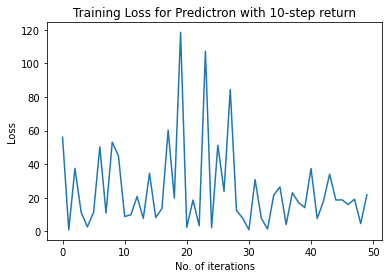

In [143]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")
plt.title("Training Loss for Predictron with "+str(k)+"-step return")

In [144]:
for p in core.parameters():
    print(p.shape)

torch.Size([64, 21])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
torch.Size([32, 4])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([2, 16])
torch.Size([2])
torch.Size([32, 4])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([4, 32])
torch.Size([4])


## Testing

In [145]:
df_test = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/test_FD001.txt")

In [146]:
x_test, y_test = getXY(df_test)

In [147]:
x_test.shape

torch.Size([13096, 21])

In [148]:
y_test.shape

torch.Size([13096, 1])

In [149]:
predict_test = core.forward(x_test)

In [150]:
loss_fn(predict_test, y_test)

tensor(352.1293, grad_fn=<MseLossBackward>)

In [153]:
df_test.iloc[20:40, 2:-2]

,time,2,3,5,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
machine,,,,,,,,,,,,,,,,,,,,,
1,31,-0.267320,1.345990,0.999962,0.261692,-1.374941,-0.870977,0.999962,0.175653,0.972392,...,0.075544,-0.193640,-0.867422,-0.808153,0.999962,0.347263,-0.582306,0.231303,-100,-100.0
2,49,0.822260,-0.354514,0.999962,0.186860,-0.301643,0.911237,0.999962,0.175653,-0.348639,...,-0.013802,0.333283,-1.182480,0.849935,0.999962,-1.274039,-0.582306,-0.879011,-100,-100.0
3,126,-0.721311,1.345990,0.999962,1.010010,0.329943,2.116325,0.999962,0.175653,-1.713704,...,-1.639885,1.211488,-0.734921,-0.480672,0.999962,1.968564,0.264669,-0.733981,-100,-100.0
4,106,0.549865,1.345990,0.999962,0.760570,1.285318,0.320655,0.999962,0.175653,-1.640314,...,0.236365,0.684565,-0.520956,1.294619,0.999962,1.968564,-2.205674,-0.922996,-100,-100.0
5,98,-0.585114,-1.374816,0.999962,-0.511569,0.367918,2.186597,0.999962,0.175653,-0.686236,...,-1.336111,1.387129,-1.296332,0.356990,0.999962,1.157913,-1.005793,0.902961,-100,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,-0.267320,1.005889,0.999962,-0.436738,0.555795,-1.016006,0.999962,0.175653,0.341233,...,0.986865,-1.071845,0.912017,-0.511696,0.999962,-1.274039,0.476412,1.484271,-100,-100.0
97,134,0.595264,-0.354514,0.999962,0.286636,-1.027168,0.924694,0.999962,0.175653,0.429301,...,-0.299706,-0.193640,1.622615,0.832699,0.999962,1.968564,-1.993930,-0.480772,-100,-100.0
98,121,0.776860,0.325687,0.999962,0.511131,2.280666,1.604985,0.999962,0.175653,-0.466064,...,-0.389052,0.333283,0.730442,-0.080800,0.999962,1.157913,-0.935212,0.297875,-100,-100.0


In [156]:
df_test.groupby('machine').last()

,time,2,3,5,6,7,8,9,10,11,...,16,17,18,19,20,21,24,25,reward,MC_Val
machine,,,,,,,,,,,,,,,,,,,,,
1,31,-0.267320,1.345990,0.999962,0.261692,-1.374941,-0.870977,0.999962,0.175653,0.972392,...,0.075544,-0.193640,-0.867422,-0.808153,0.999962,0.347263,-0.582306,0.231303,-100,-100.0
2,49,0.822260,-0.354514,0.999962,0.186860,-0.301643,0.911237,0.999962,0.175653,-0.348639,...,-0.013802,0.333283,-1.182480,0.849935,0.999962,-1.274039,-0.582306,-0.879011,-100,-100.0
3,126,-0.721311,1.345990,0.999962,1.010010,0.329943,2.116325,0.999962,0.175653,-1.713704,...,-1.639885,1.211488,-0.734921,-0.480672,0.999962,1.968564,0.264669,-0.733981,-100,-100.0
4,106,0.549865,1.345990,0.999962,0.760570,1.285318,0.320655,0.999962,0.175653,-1.640314,...,0.236365,0.684565,-0.520956,1.294619,0.999962,1.968564,-2.205674,-0.922996,-100,-100.0
5,98,-0.585114,-1.374816,0.999962,-0.511569,0.367918,2.186597,0.999962,0.175653,-0.686236,...,-1.336111,1.387129,-1.296332,0.356990,0.999962,1.157913,-1.005793,0.902961,-100,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,-0.267320,1.005889,0.999962,-0.436738,0.555795,-1.016006,0.999962,0.175653,0.341233,...,0.986865,-1.071845,0.912017,-0.511696,0.999962,-1.274039,0.476412,1.484271,-100,-100.0
97,134,0.595264,-0.354514,0.999962,0.286636,-1.027168,0.924694,0.999962,0.175653,0.429301,...,-0.299706,-0.193640,1.622615,0.832699,0.999962,1.968564,-1.993930,-0.480772,-100,-100.0
98,121,0.776860,0.325687,0.999962,0.511131,2.280666,1.604985,0.999962,0.175653,-0.466064,...,-0.389052,0.333283,0.730442,-0.080800,0.999962,1.157913,-0.935212,0.297875,-100,-100.0


In [160]:
y_target[180:200,:]

tensor([[-3.1381e+01],
        [-3.4868e+01],
        [-3.8742e+01],
        [-4.3047e+01],
        [-4.7830e+01],
        [-5.3144e+01],
        [-5.9049e+01],
        [-6.5610e+01],
        [-7.2900e+01],
        [-8.1000e+01],
        [-9.0000e+01],
        [-1.0000e+02],
        [-8.1914e-12],
        [-9.1015e-12],
        [-1.0113e-11],
        [-1.1236e-11],
        [-1.2485e-11],
        [-1.3872e-11],
        [-1.5414e-11],
        [-1.7126e-11]])

In [161]:
core.forward(x[180:200,:])

tensor([[-2.3191e+01],
        [-3.7794e+01],
        [-2.6134e+01],
        [-8.0198e+01],
        [-6.3151e+01],
        [-4.3087e+01],
        [-6.9333e+01],
        [-5.0656e+01],
        [-8.4726e+01],
        [-8.6461e+01],
        [-7.3645e+01],
        [-8.3484e+01],
        [-3.7174e-02],
        [-1.4892e-01],
        [-5.3861e-01],
        [-1.5128e-01],
        [-4.8330e-01],
        [-6.8250e-02],
        [-1.2240e-01],
        [-1.2974e-01]], grad_fn=<ViewBackward>)